In [138]:
import simpy
import math
import numpy as np
from functools import reduce
from tabulate import tabulate
import matplotlib.pyplot as plt

# Multichannel Queuing System Simulation processes class
class QueuingSystemSimulation:
    def __init__(self, n, m, lambd, mu, v, env):
        # queuing system params
        self.n = n
        self.m = m
        self.lambd = lambd
        self.mu = mu
        self.v = v
        # empirical values lists
        self.L_queuing_system_list = []
        self.L_queue_list = []
        self.t_queuing_system_list = []
        self.t_queue_list = []
        # enviromental variables for simpy simulation
        self.env = env
        self.loader = simpy.Resource(env, n)

    # Multichannel Queuing Simulation with parameters n, m, lambd, mu, v, test_time
    @staticmethod
    def simulate_queuing_system(n, m, lambd, mu, v, test_time):
        env = simpy.Environment()
        qs = QueuingSystemSimulation(n, m, lambd, mu, v, env)
        env.process(qs.run())
        env.run(until=test_time)
        return qs

    def run(self):
        while True:
            yield self.env.timeout(np.random.exponential(1/self.lambd))
            self.env.process(self.make_request())

    def make_request(self):
        queque_len_before = len(self.loader.queue)
        n_busy = self.loader.count

        with self.loader.request() as request:
            self.L_queue_list.append(queque_len_before)
            self.L_queuing_system_list.append(queque_len_before + n_busy)
            if len(self.loader.queue) <= self.m:
                arrival_time = self.env.now

                waiting_process = self.env.process(self.waiting_in_queue())
                result = yield request | waiting_process    

                self.t_queue_list.append(self.env.now - arrival_time)
                if request in result:
                    yield self.env.process(self.request_processing())
                    self.t_queuing_system_list.append(self.env.now - arrival_time)
                else:
                    self.t_queuing_system_list.append(self.env.now - arrival_time)
            else:
                self.t_queue_list.append(0)
                self.t_queuing_system_list.append(0)

    def request_processing(self):
        yield self.env.timeout(np.random.exponential(1/self.mu))

    def waiting_in_queue(self):
        yield self.env.timeout(np.random.exponential(1/self.v))

    def get_results(self):
        return self.L_queuing_system_list, self.L_queue_list, self.t_queuing_system_list, self.t_queue_list

Empirical Characteristics

In [139]:
# Calculate Empirical Characteristics
def calculate_empirical_characteristics(qs):
    L_queuing_system_list, L_queue_list, t_queuing_system_list, t_queue_list = qs.get_results()
    p = []
    for i in range(qs.n + qs.m + 1):
        request_frequency = reduce( lambda count, x: count+1 if x == i else count, L_queuing_system_list, 0)
        p.append(request_frequency / len(L_queuing_system_list))
    p_reject = p[qs.n + qs.m]
    Q = 1 - p_reject
    A = qs.lambd * Q
    n_occuped = Q * qs.lambd / qs.mu
    L_queue = sum(L_queue_list) / len(L_queue_list)
    L_queuing_system = sum(L_queuing_system_list) / len(L_queuing_system_list)
    t_queuing_system = sum(t_queuing_system_list) / len(t_queuing_system_list)
    t_queue = sum(t_queue_list) / len(t_queue_list)

    return p, Q, A, p_reject, n_occuped, L_queuing_system, L_queue, t_queuing_system, t_queue

Theoretical Characteristics

In [140]:
# Calculate Theoretical Characteristics
def calculate_theoretical_characteristics(n, m, lambd, mu, v):
    alpha = lambd / mu
    betta = v / mu 
    p=[]
    p_0 = (
                 sum([alpha ** i / math.factorial(i) for i in range (n+1)]) +
                 alpha ** n / math.factorial(n) *
                 sum([alpha ** i / reduce( 
                     lambda prod, x: prod * x, [ (n + l * betta) for l in range(1, i + 1) ] 
                 ) for i in range(1,m+1)])
           ) ** (-1)
    p.append(p_0)
    for k in range(1,n + 1):
        p_k = alpha ** k / math.factorial(k) * p[0]
        p.append(p_k)
    for i in range(1,m + 1):
        p_n_i = p[n] * alpha ** i / reduce( 
                     lambda prod, x: prod * x, [ (n + l * betta) for l in range(1,i + 1) ] 
                 )
        p.append(p_n_i)
    p_reject = p[n + m]
    Q = 1 - p_reject
    A = lambd * Q
    L_queue = sum([ i * p[n + i] for i in range(1,m + 1)])
    n_occuped = Q * lambd / mu
    L_queuing_system = sum([k * p[k] for k in range(1, n + 1)]) + sum([(n + i) * p[n + i] for i in range(1, m + 1)])
    t_queuing_system = L_queuing_system / lambd
    t_queue = L_queue / lambd

    return p, Q, A, p_reject, n_occuped, L_queuing_system, L_queue, t_queuing_system, t_queue

In [141]:
def display_characteristics(theoretical_characteristics, empirical_characteristics):
    p1, Q1, A1, p_reject1, n_occuped1, L_queuing_system1, L_queue1, t_queuing_system1, t_queue1 = theoretical_characteristics
    p2, Q2, A2, p_reject2, n_occuped2, L_queuing_system2, L_queue2, t_queuing_system2, t_queue2 = empirical_characteristics

    output_list = [[f'p{(i)}', p1[i], p2[i]] for i in range (min(len(p1), 15))]
    output_list.extend([['Q (относительная пропускная способность)', Q1, Q2],
                        ['A (абсолютная пропускная способность)', A1, A2],
                        ['p отказа', p_reject1, p_reject2],
                        ['L СМО (среднее число заявок в СМО)', L_queuing_system1, L_queuing_system2],
                        ['L очереди (среднее число заявок в очереди)', L_queue1, L_queue2],
                        ['t СМО (среднее время заявки в СМО)', t_queuing_system1, t_queuing_system2],
                        ['t очереди (среднее время заявки в очереди)', t_queue1, t_queue2],
                        ['n занятости (среднее число занятых каналов)', n_occuped1, n_occuped2]])
    print(tabulate(output_list,
          headers=['', 'Теоретические характеристики', 'Эмпирические характеристики']))
    print()

In [142]:
def plot_graphs(theoretical_characteristic, empirical_characteristic):
    plt.plot(theoretical_characteristic[0])
    plt.plot(empirical_characteristic[0])
    plt.legend(['Теоретические вероятности', 'Эмпирические вероятности'])
    plt.xlabel('p[i]')
    plt.show()

def get_xi_2(o, e):
    return sum(((o[i] - e[i]) ** 2) / e[i] for i in range(len(o)))

Tests

In [143]:
def test_analyse(n, m, lambd, mu, v):
    print(f'Характеристики СМО: n={n}, m={m}, lambda={lambd}, mu={mu}, v={v}')
    theoretical_characteristics = calculate_theoretical_characteristics(n, m, lambd, mu, v)

    qs = QueuingSystemSimulation.simulate_queuing_system(n, m, lambd, mu, v, 10000)
    empirical_characteristics = calculate_empirical_characteristics(qs)

    display_characteristics(theoretical_characteristics, empirical_characteristics)

    t_estimation_list = theoretical_characteristics[0] + [
        theoretical_characteristics[i] for i in range(1, len(theoretical_characteristics))
    ]
    e_estimation_list = empirical_characteristics[0] + [
        empirical_characteristics[i] for i in range(1, len(empirical_characteristics))
    ]

    xi_2_estimation = get_xi_2(e_estimation_list, t_estimation_list)
    print('Xi-квадрат:', xi_2_estimation)

    plot_graphs(theoretical_characteristics, empirical_characteristics)

Характеристики СМО: n=3, m=3, lambda=2, mu=1, v=1
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                                0.135952                       0.131669
p1                                                                0.271903                       0.269404
p2                                                                0.271903                       0.276925
p3                                                                0.181269                       0.183765
p4                                                                0.0906344                      0.0916566
p5                                                                0.0362538                      0.0348977
p6                                                                0.0120846                      0

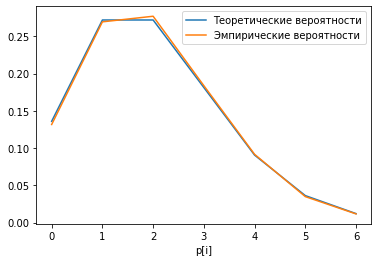

In [144]:
test_analyse(n = 3, m = 3, lambd = 2, mu = 1, v = 1)

Характеристики СМО: n=3, m=2, lambda=5, mu=1, v=2
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                                0.0133249                      0.0130872
p1                                                                0.0666244                      0.0656748
p2                                                                0.166561                       0.168583
p3                                                                0.277602                       0.276841
p4                                                                0.277602                       0.276244
p5                                                                0.198287                       0.19957
Q (относительная пропускная способность)                          0.801713                       0.

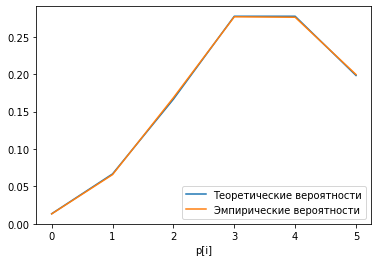

In [145]:
test_analyse(n = 3, m = 2, lambd = 5, mu = 1, v = 2)

Характеристики СМО: n=8, m=6, lambda=18, mu=4, v=3
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                              0.011077                       0.0107665
p1                                                              0.0498463                      0.0509208
p2                                                              0.112154                       0.11415
p3                                                              0.168231                       0.170254
p4                                                              0.18926                        0.189248
p5                                                              0.170334                       0.171284
p6                                                              0.127751                       0.126319
p7    

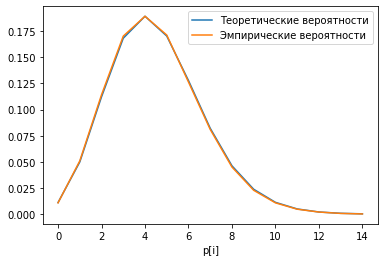

In [146]:
test_analyse(n = 8, m = 6, lambd = 18, mu = 4, v = 3)

Характеристики СМО: n=2, m=30, lambda=50, mu=3, v=2
                                               Теоретические характеристики    Эмпирические характеристики
-------------------------------------------  ------------------------------  -----------------------------
p0                                                              2.74041e-10                    1.99651e-06
p1                                                              4.56735e-09                    1.99651e-06
p2                                                              3.80612e-08                    1.99651e-06
p3                                                              2.37883e-07                    1.99651e-06
p4                                                              1.18941e-06                    1.99651e-06
p5                                                              4.95589e-06                    3.99303e-06
p6                                                              1.76996e-05                 

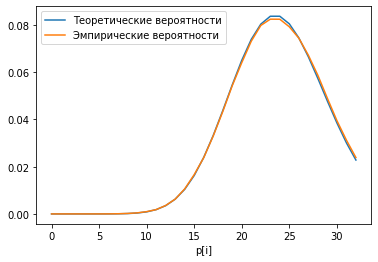

In [149]:
test_analyse(n = 2, m = 30, lambd = 50, mu = 3, v = 2)